# Degradation example


This juypter notebook is intended to test the degradation analysis workflow.  In addition, the notebook demonstrates the effects of changes in the workflow.

Degradation analysis of PV systems includes several steps:
1. <b>Standardize</b> data inputs
2. <b>Normalize</b> data using a performance metric
3. <b>Filter</b> data that creates bias 
4. <b>Analyze</b> aggregated data to estimate the degradation rate



In [1]:
# Enable inline plotting
%matplotlib inline

# Backport python3 division behavior
from __future__ import division

from urllib import urlencode
import datetime
from datetime import datetime
from datetime import timedelta
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import os

import pytz
from pprint import pprint

from sklearn.linear_model import LinearRegression
import seaborn as sns

# Set plotting configuration
sns.set_palette('deep', desat=.8)
sns.set_context('notebook', font_scale=1.5, rc={'figure.figsize': (16,5)})
font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 24}
plt.rc('font', **font)

import matplotlib
matplotlib.rcParams.update({'font.size': 12,
                           'figure.figsize': [4.5, 3],
                           'lines.markeredgewidth': 0,
                           'lines.markersize': 2
                           })

In [2]:
import pvlib
import rdtools
from pathlib2 import Path

print pvlib.__version__
print rdtools.__version__

/Users/anag/anaconda/envs/python2.7/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


0.4.5
1.0.1+59.g0fba2b2.dirty


# 1. <b>Standardize</b>

Please download the annual csv data for system with system id 39, using the PVDAQ API, and store the csv file in the folder:
./rdtools/docs/

https://developer.nrel.gov/docs/solar/pvdaq-v3/data_file/

The following script loads the data, parses a pandas.DateTimeIndex, and renames the critical pandas.Series objects.



In [3]:
systemid=39
api_key='ZRHhZvBE4s40rAkPi1A1jyyjOA4KIF5ULinBPmEd'
pvdaq_metadata_url = 'http://developer.nrel.gov/api/pvdaq/v3/sites.xml?system_id=' + str(systemid) + '&api_key=' + api_key

In [4]:
pvdaq_metadata_url

'http://developer.nrel.gov/api/pvdaq/v3/sites.xml?system_id=39&api_key=ZRHhZvBE4s40rAkPi1A1jyyjOA4KIF5ULinBPmEd'

In [5]:
import urllib2
import xmltodict
import xml.etree.ElementTree as et

file = urllib2.urlopen(pvdaq_metadata_url)
tree = et.parse(file)
file.close()

root = tree.getroot()



avail_year = [int(avail_year.text) for avail_year in root.iter('available-year')]
start_year = avail_year[0]
end_year = avail_year[-1]
inverter_mfg = [str(inv_mfg.text) for inv_mfg in root.iter('inverter-mfg')][0]
inverter_model = [str(inv_model.text) for inv_model in root.iter('inverter-model')][0]
module_mfg = [str(mod_mfg.text) for mod_mfg in root.iter('module-mfg')][0]
module_model = [str(mod_model.text) for mod_model in root.iter('module-model')][0]
power = [float(site_power.text) for site_power in root.iter('site-power')][0]
area = [float(site_area.text) for site_area in root.iter('site-area')][0]
azimuth = [float(site_azimuth.text) for site_azimuth in root.iter('site-azimuth')][0]
elevation = [float(site_elevation.text) for site_elevation in root.iter('site-elevation')][0]
lat = [float(site_lat.text) for site_lat in root.iter('site-latitude')][0]
lon = [float(site_lon.text) for site_lon in root.iter('site-longitude')][0]
lon = -lon
tilt = [float(site_tilt.text) for site_tilt in root.iter('site-tilt')][0]
name = [str(name_priv.text) for name_priv in root.iter('name-private')][0]

In [6]:
avail_year

[1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017]

In [7]:
year = 2002
pvdaq_ann_csv_url = 'http://developer.nrel.gov/api/pvdaq/v3/data_file.csv?api_key=' + api_key + '&system_id=' + str(systemid)+ '&year=' + str(year)

In [8]:
list_years = avail_year[9:]

In [9]:
list_years

[2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017]

In [10]:
# Read data frame from hdf5 file if available 
# Otherwise create data frame and store in hdf5 file
# for future use
hdf_filename = 'ASE.h5'
hdf_key = 'ASE_hdf5'
hdf_dir = './'
hdf_file = Path(hdf_dir + hdf_filename)  # Specify path to hdf file
if hdf_file.exists():
    df = pd.read_hdf(hdf_dir + hdf_filename, hdf_key)
else:    
    df = pd.DataFrame()
    for year in list_years:
        pvdaq_ann_csv_url = 'http://developer.nrel.gov/api/pvdaq/v3/data_file.csv?api_key=' + api_key + '&system_id=' + str(systemid)+ '&year=' + str(year)
        data = pd.read_csv(pvdaq_ann_csv_url)
        df = df.append(data)
    df.to_hdf(hdf_dir + hdf_filename, hdf_key)

In [11]:
df.head()

,ACVA,ACVar,AC_VARhoursnet,AC_Watthoursnet,DC_power,Date-Time,EPO_Status,EPO_status,GH_irradiance,Module10NW_Temp,...,unbiased_module_temp_3_2,unbiased_module_temp_3_3,unbiased_temp,wetness_kOhms,wind_direction,wind_direction_unc,wind_speed,wind_speed_unc,wind_speed_xvec,wind_speed_yvec
0,NaN,NaN,NaN,NaN,NaN,2004-01-01 00:00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,2004-01-01 00:15:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,2004-01-01 00:30:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,2004-01-01 00:45:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,2004-01-01 01:00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
type(df['Date-Time'])

pandas.core.series.Series

In [13]:
df['Date-Time'] = pd.to_datetime(df['Date-Time'])

In [14]:
df.set_index('Date-Time', inplace=True)

In [15]:
df.index

DatetimeIndex(['2004-01-01 00:00:00', '2004-01-01 00:15:00',
               '2004-01-01 00:30:00', '2004-01-01 00:45:00',
               '2004-01-01 01:00:00', '2004-01-01 01:15:00',
               '2004-01-01 01:30:00', '2004-01-01 01:45:00',
               '2004-01-01 02:00:00', '2004-01-01 02:15:00',
               ...
               '2017-08-09 19:51:00', '2017-08-09 19:52:00',
               '2017-08-09 19:53:00', '2017-08-09 19:54:00',
               '2017-08-09 19:55:00', '2017-08-09 19:56:00',
               '2017-08-09 19:57:00', '2017-08-09 19:58:00',
               '2017-08-09 19:59:00', '2017-08-09 20:00:00'],
              dtype='datetime64[ns]', name=u'Date-Time', length=4091341, freq=None)

In [16]:
# There is some missing data, but we can infer the frequency from the first several data points
freq = pd.infer_freq(df.index[:10])

# And then set the frequency of the dataframe
df = df.resample(freq).asfreq()

In [17]:
print pd.infer_freq(df.index)

15T


In [18]:
timezone = pytz.timezone("Etc/GMT+7")
df.index = df.index.tz_localize(timezone)

In [19]:
module_temp = df.filter(regex=("module_temp*"))
module_temp = module_temp.median(axis=1)
df['module_temperature'] = module_temp

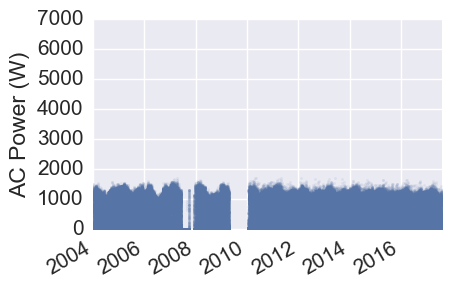

In [20]:
# plot the AC power time series
fig, ax = plt.subplots()
ax.plot(df.index, df.ac_power, 'o', alpha = 0.1)
ax.set_ylim(0,7000)
fig.autofmt_xdate()
ax.set_ylabel('AC Power (W)');

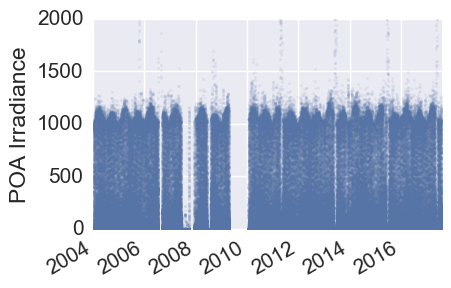

In [21]:
# plot the POA irradiance time series
fig, ax = plt.subplots()
ax.plot(df.index, df.poa_irradiance, 'o', alpha = 0.1)
ax.set_ylim(0,2000)
fig.autofmt_xdate()
ax.set_ylabel('POA Irradiance');

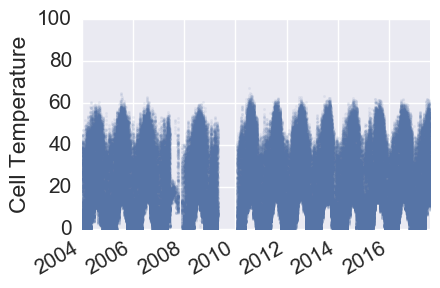

In [22]:
# plot the cell temperature time series
fig, ax = plt.subplots()
ax.plot(df.index, df.module_temperature, 'o', alpha = 0.1)
ax.set_ylim(0,100)
fig.autofmt_xdate()
ax.set_ylabel('Cell Temperature');

In [23]:
# Calculate energy yield in kWh
df['energy'] = df.ac_power * pd.to_timedelta(df.ac_power.index.freq).total_seconds()/(3600.0)

# 2. <b>Normalize</b> 

Data normalization typically requires some additional metadata about the PV system power time series.  Metadata consists of site location information, module product details, PV circuit configuration, and other items.

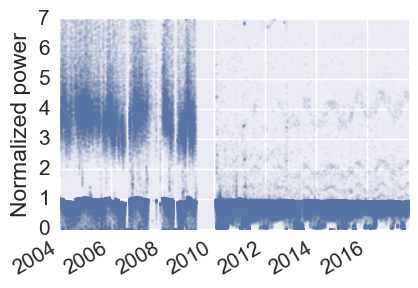

In [24]:
# Metadata
pdc = 1400 # System size in W

pvwatts_kws = {"poa_global" : df.poa_irradiance,
              "P_ref" : pdc,
              "T_cell" : df.module_temperature,
              "G_ref" : 1000,
              "T_ref" : 20,
              "gamma_pdc" : -0.00506}

normalized, insolation = rdtools.normalize_with_pvwatts(df.energy, pvwatts_kws)

df['normalized'] = normalized
df['insolation'] = insolation


# Plot the normalized power time series
fig, ax = plt.subplots()
ax.plot(normalized.index, normalized, 'o', alpha = 0.05)
ax.set_ylim(0,7)
fig.autofmt_xdate()
ax.set_ylabel('Normalized power');

# 3. <b>Filter</b> 

Data filtering is used to exclude data points that represent invalid data, create bias in the analysis, or introduce significant noise.


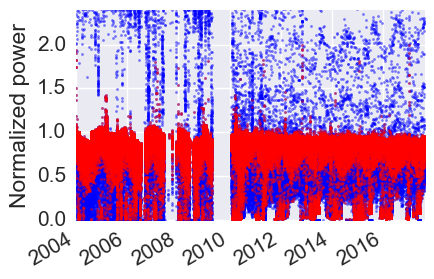

In [25]:
# Perform rudimetary filtering, more advanced filtering will be integrated
# into Rdtools in the future
filter_criteria = ((df['normalized']>0) & (df['normalized']<2) & (df.poa_irradiance>200))

filtered = df[filter_criteria]
filtered = filtered[['insolation', 'normalized']]



# Plot the normalized and filtered power time series
fig, ax = plt.subplots()
ax.plot(normalized.index, normalized, 'o', color='b', alpha = 0.5)
ax.plot(filtered.index, filtered.normalized, 'o', color='r', alpha = 0.5)
ax.set_ylim(0,2.4)
fig.autofmt_xdate()
ax.set_ylabel('Normalized power');

# 4. <b>Aggregate</b>

Data is aggregated with an irradiance weighted average. This can be useful, for example with daily aggregation, to reduce the impact of high-error data points in the morning and evening.

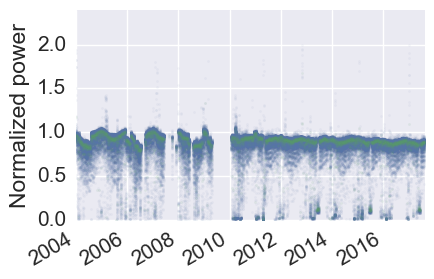

In [26]:
daily = rdtools.aggregation_insol(filtered.normalized, filtered.insolation)

# Plot the normalized and filtered power time series along with the aggregation
fig, ax = plt.subplots()
ax.plot(filtered.index, filtered.normalized, 'o', alpha = 0.05)
ax.plot(daily.index, daily, 'o', alpha = 0.1)
ax.set_ylim(0,2.4)
fig.autofmt_xdate()
ax.set_ylabel('Normalized power');

# 5. <b>Degradation calculation</b>

Data is then analyzed to estimate the degradation rate representing the PV system behavior.

In [27]:
ols_rd, ols_ci, ols_info = rdtools.degradation_ols(daily)
print '''The degradation rate calculated with ols is %0.2f %%/year
with a confidence interval of %0.2f to %0.2f %%/year
''' % (ols_rd, ols_ci[0], ols_ci[1])

yoy_rd, yoy_ci, yoy_info = rdtools.degradation_year_on_year(daily)
print '''The degradation rate calculated with year on year is %0.2f %%/year
with a confidence interval of %0.2f to %0.2f %%/year
''' % (yoy_rd, yoy_ci[0], yoy_ci[1])

The degradation rate calculated with ols is -0.85 %/year
with a confidence interval of -0.92 to -0.77 %/year

The degradation rate calculated with year on year is -0.66 %/year
with a confidence interval of -0.74 to -0.59 %/year



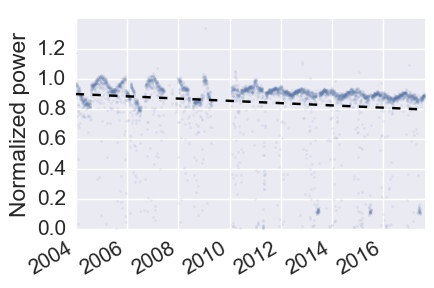

In [28]:
# plot the regression through the normalized data 
fig, ax = plt.subplots()
ax.plot(daily.index, daily, 'o', alpha = 0.1)
x_vals = np.array(ax.get_xlim())
y_vals = ols_info['intercept'] + ols_info['slope'] * (x_vals-min(x_vals)) / 365
ax.plot(x_vals, y_vals, '--k')

ax.set_ylim(0,1.4)
fig.autofmt_xdate()
ax.set_ylabel('Normalized power');

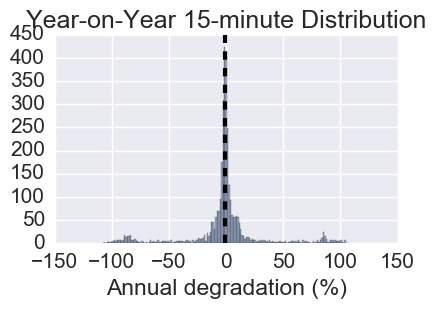

In [29]:
# Plot the year-on-year distribution
# Note that the uncertainty is from bootstrapping the median
# not the standard deviation of the plotted distribution
yoy_values = yoy_info['YoY_values']
plt.hist(yoy_values, alpha=0.5, label='YOY', bins=int(yoy_values.__len__()/20))
plt.axvline(x=yoy_rd, color='black', linestyle='dashed', linewidth=3)
#plt.legend(loc='upper right')
plt.title('Year-on-Year 15-minute Distribution')   
plt.tight_layout(w_pad=1, h_pad=2.0)
plt.xlabel('Annual degradation (%)');